In [1]:
# !pip install pandas
# !pip install --upgrade praw
!pip install --upgrade networkx 
# !pip install matplotlib
# !pip install plotly
# !pip install numpy
# !pip install scikit-learn
# !pip install wordcloud
# !pip install nltk
# !pip install chardet


In [1]:
from datetime import datetime
import pandas as pd
import praw
import json
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from sklearn.cluster import KMeans


from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import re

from gensim import corpora, models
import gensim

### Load data from reddit  

In [7]:
# Function to read credentials from a JSON file
def load_credentials(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Load credentials
credentials = load_credentials('reddit_secrets.json')

# Initialize PRAW with credentials from the JSON file
reddit = praw.Reddit(client_id=credentials['client_id'],
                     client_secret=credentials['client_secret'],
                     user_agent=credentials['user_agent'])


# Function to get comments from a post
def get_comments(submission):
    submission.comments.replace_more(limit=0)  # Load all comments
    comments = []
    for comment in submission.comments.list():
        if str(comment.author) != 'None':
            comments.append({
                'author': str(comment.author),
                'body': comment.body,
                'created_utc': datetime.utcfromtimestamp(comment.created_utc).isoformat(),
                'score': comment.score
            })
    return comments


# Function to get author details
def get_author_details(author_name):
    try:
        author = reddit.redditor(author_name)
        author_subreddit = getattr(author, 'subreddit', None)  # Get the UserSubreddit object
        return {
            'name': getattr(author, 'name', 'Anonymous'),
            'description': getattr(author_subreddit, 'public_description', '') if author_subreddit else None,
            'total_karma': getattr(author, 'link_karma', 0) + getattr(author, 'comment_karma', 0),  # Total karma (post + comment)
            'link_karma': getattr(author, 'link_karma', 0),  # Link karma
            'comment_karma': getattr(author, 'comment_karma', 0),  # Comment karma
            'account_created_utc': datetime.utcfromtimestamp(getattr(author, 'created_utc', 0)).isoformat() if getattr(author, 'created_utc', None) else None,  # Account creation date
            'is_employee': getattr(author, 'is_employee', False),  # Reddit employee status
            'has_verified_email': getattr(author, 'has_verified_email', False)  # Whether the user has a verified email
        }
    except Exception as e:
        print(f"Error fetching author details: {e}")
        return None


# Function to get post details and comments
def get_posts(subreddit_name, keyword_limit=10):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    count = 0

    for post in subreddit.top(limit=None):  # Search through a larger pool of posts
        if (str(post.author) != 'None'):
            author_details = get_author_details(str(post.author))
            post_data = {
                'title': post.title,
                'score': post.score,
                'id': post.id,
                'url': post.url,
                # 'author': str(post.author),
                'author_details': author_details,
                'created_utc': datetime.utcfromtimestamp(post.created_utc).isoformat(),
                'num_comments': post.num_comments,
                'selftext': post.selftext,
                'link_flair_text': post.link_flair_text,
                'upvote_ratio': post.upvote_ratio,
                'subreddit': str(post.subreddit),
                'all_awardings': post.all_awardings,
                'permalink': post.permalink,
                'stickied': post.stickied,
                'locked': post.locked,
                'domain': post.domain,
                'comments': get_comments(post)
            }
            posts.append(post_data)
            count += 1
            if count >= keyword_limit:
                break
    return posts

# Extract DisneyParks-related posts and comments from the subreddit
subreddit_name = 'disneyparks'
data = get_posts(subreddit_name, keyword_limit=100)

# Save data to a JSON file
with open('reddit_data_Disneyland.json', 'w') as file:
    json.dump(data, file, indent=4)

print("Data saved to 'reddit_data_Disneyland.json'")


Data saved to 'reddit_data_Disneyland.json'


### Create a network of the authors and contributors 

In [8]:
# Load data
with open('reddit_data_Disneyland.json', 'r') as file:
    data = json.load(file)

# Create a graph
G = nx.Graph()

# Add nodes and edges
for item in data:
    if item['author_details'] == None:
        print(item)
    post_author = item['author_details']['name']
    G.add_node(post_author)

    for comment in item['comments']:
        commenter = comment['author']
        G.add_node(commenter)
        G.add_edge(post_author, commenter)  # Create an edge between post author and commenter


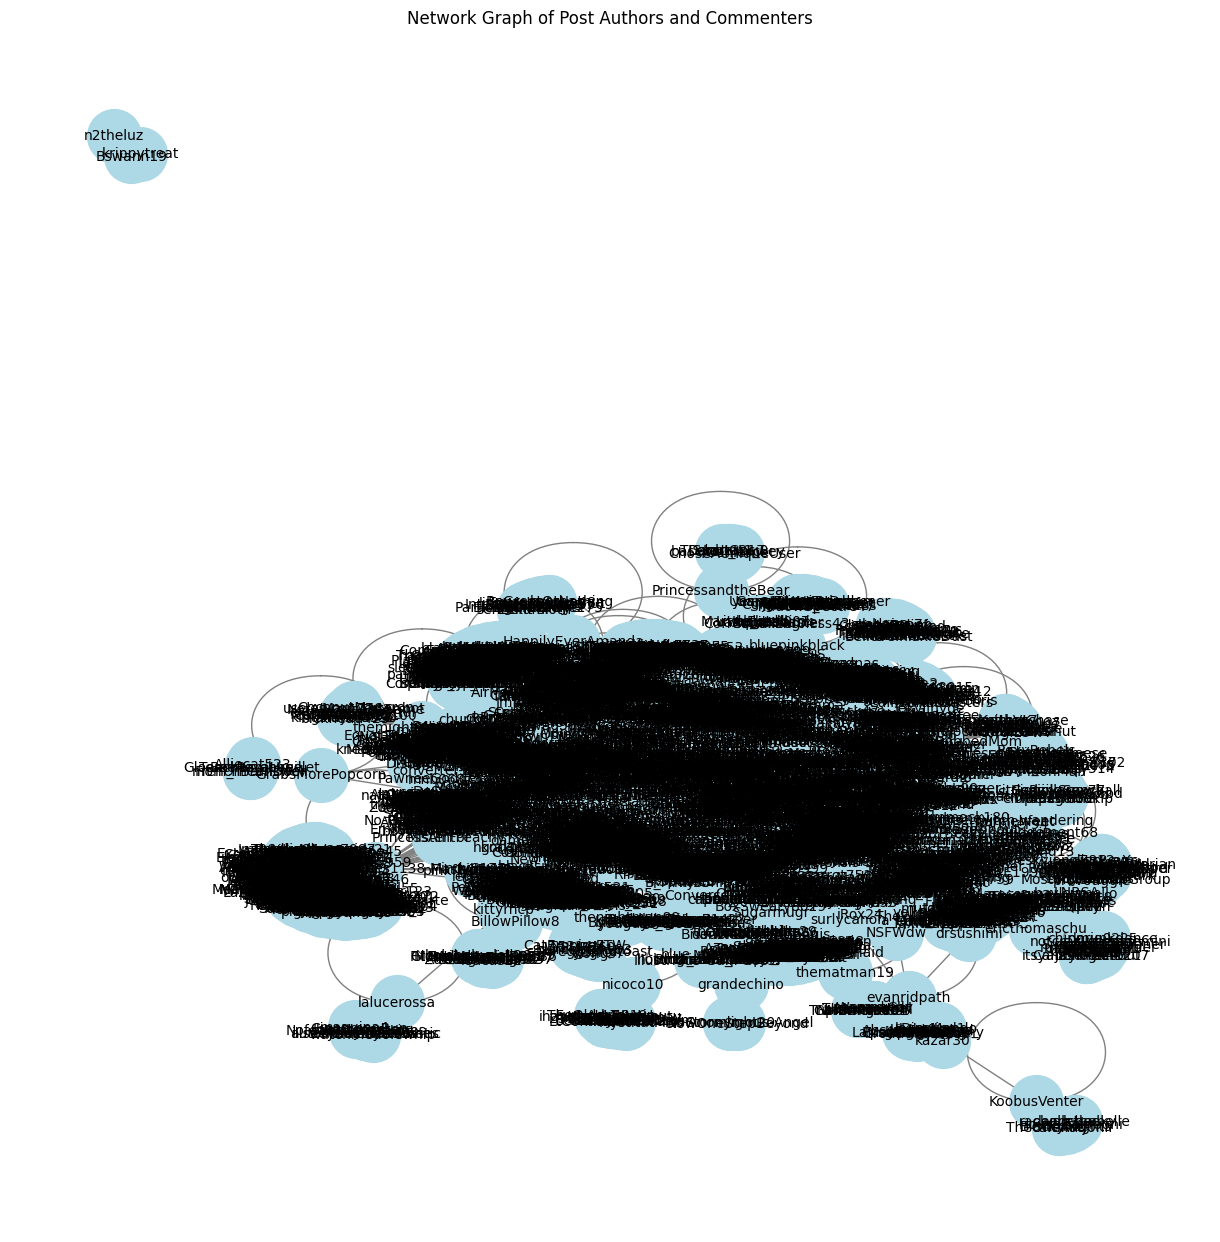

In [9]:
# Draw the network
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', 
        node_size=1500, font_size=10)
plt.title("Network Graph of Post Authors and Commenters")
plt.show()


In [10]:
nx.__version__

'3.1'

In [11]:
# Get positions for the nodes in G
pos = nx.spring_layout(G)

# For each edge, we need to extract the positions of the start and end nodes
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create a trace for the edges
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# For each node, we need to extract the positions and centrality measures
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Create a trace for the nodes
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        color=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Color node points by the number of connections
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'{adjacencies[0]} (# of connections: {len(adjacencies[1])})')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network Graph of Post Authors and Commenters',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


In [12]:
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display top influencers
top_influencers = sorted_centrality[:5] 



In [13]:
print("Top influencers based on degree centrality:")

df_top_influencers = pd.DataFrame(top_influencers, columns=['Contributor', 'Degree Centrality'])

df_top_influencers

Top influencers based on degree centrality:


Contributor  Degree Centrality
0       solojones1138           0.104323
1           Quizchris           0.068296
2  AirMagiqueOfficial           0.065476
3             JPfan05           0.057018
4     xJenniferocious           0.054511

### Text processing using NLTK 

In [14]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define a set of English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/ankush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ankush/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/ankush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ankush/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
# Extend the stopwords list with custom words
additional_stopwords = {'like', 'people', 'think', 'would', 'know', 'also', 'even', 'one', 'really', 'get', 
                        'thing', 'https', 'really', 'use', 'year', 'lol'}
extended_stopwords = set(stopwords.words('english')).union(additional_stopwords)

def preprocess_text(text):
    # Decode and re-encode text to handle encoding issues
    # text = text.encode('latin-1').decode('unicode_escape').encode('latin-1').decode('utf-8')

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|@\w+|\#\w+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and custom additional words
    tokens = [token for token in tokens if token not in extended_stopwords]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Filter only nouns
    nouns = [word for word, pos in pos_tag(tokens) if pos.startswith('NN')]

    # Remove short words (less than 3 characters) and digits
    nouns = [word for word in nouns if len(word) > 2 and not word.isdigit()]

    return nouns

In [16]:
num_comments_per_contributor = {}

for item in data:
    # Count the post itself by the author
    post_author = item['author_details']['name']
    num_comments_per_contributor[post_author] = num_comments_per_contributor.get(post_author, 0) + 1

    # Iterate through comments and count them
    for comment in item['comments']:
        commenter = comment['author']
        num_comments_per_contributor[commenter] = num_comments_per_contributor.get(commenter, 0) + 1

In [17]:
num_comments_per_contributor

{'MeganTheCartoonist': 6,
 'SchleppyJ4': 5,
 'Warhawkgame128': 3,
 'm4imaimai': 1,
 'puffmouse': 1,
 'Italianman2733': 1,
 'Sirstupifie': 1,
 'jmairena20': 1,
 'rawrtherapy': 2,
 'faderjockey': 2,
 'ReactorCritical': 2,
 'D0nK3yd0Ng': 5,
 'Louiekid502': 1,
 'ghostwiththeleast': 1,
 'tayLORDoc': 6,
 'Curlyspice97': 3,
 'lewiss15': 1,
 'killerqween16': 1,
 'feelthebernerd': 4,
 'cncordray': 2,
 'Pegasus2731': 1,
 'RainbowDash0201': 1,
 'TheOneTrueAnimeLover': 1,
 'CCatProductions': 2,
 'Soflo-anarchy-crew': 1,
 'ilikescolouring': 1,
 'osmosis19': 1,
 'B1g_Ron': 6,
 'MithranArkanere': 1,
 'QueenB_50': 1,
 'I_dont_cuddle': 2,
 'WellDressedLobster': 6,
 'AnneHasThePlague2': 1,
 'SpartanElitism': 8,
 'john_muleaney': 3,
 'cutielocks': 1,
 'Wildcat_twister12': 4,
 'WoodFirePizzaIsGood': 2,
 'stellalunawitchbaby': 4,
 'RhymesWithMouthful': 4,
 'GoldenOwl25': 3,
 'BadJubie': 3,
 'joshysgirl7': 3,
 'elevatorfloor': 2,
 'Johnny-Sins_6942': 2,
 'anonuck': 2,
 'Five_Magix': 3,
 'scorpio_babe': 4,
 

In [18]:
contributor_texts = {}

for item in data:
    # Count the post itself by the author
    post_author = item['author_details']['name']
    text_comm = [' '.join(preprocess_text(item['title'])) + ' ' + ' '.join(preprocess_text(item['selftext']))]
    if text_comm != ['']:
        contributor_texts[post_author] = contributor_texts.get(post_author, []) + text_comm
    else:
        contributor_texts[post_author] = contributor_texts.get(post_author, [])

    # Iterate through comments and count them
    for comment in item['comments']:
        commenter = comment['author']
        text_comm = [' '.join(preprocess_text(comment['body']))]
        if text_comm != ['']:
            contributor_texts[commenter] = contributor_texts.get(commenter, []) + text_comm
        else:
            contributor_texts[commenter] = contributor_texts.get(commenter, [])

In [19]:
contributor_texts

{'MeganTheCartoonist': ['congratulation tiana rafiki change ',
  'thanks',
  'hope',
  'breath',
  'imagine ride vehicle alligator liking'],
 'SchleppyJ4': ['loss childhood pure future ride music ride head movin',
  'end sequence river boat',
  'anything colony point',
  'town city purchase colonist anything colony state disney reason expand meaning representation purchase frontier explore nola city aka day fit',
  'thing park time matter'],
 'Warhawkgame128': ['change damn gon rabbit',
  'wdw monorail bland nostalgic',
  'elevator kinda meh work floor door'],
 'm4imaimai': ['change situation outcome splash mountain'],
 'puffmouse': ['bee part theme'],
 'Italianman2733': ['ride music see karen'],
 'Sirstupifie': ['hope brare rabbit'],
 'jmairena20': ['need change type change need time'],
 'rawrtherapy': ['move princess frog makeover man scene river scene',
  'holy idea'],
 'faderjockey': ['drive system caster house motor'],
 'ReactorCritical': ['thx art nice change',
  'story story eve

In [20]:
degree_centrality = nx.degree_centrality(G)


# Prepare the feature matrix X
contributors = list(degree_centrality.keys())  # List of contributors
features = []
for contributor in contributors:
    features.append([
        degree_centrality[contributor],  # Degree centrality
        num_comments_per_contributor.get(contributor, 0)  # Number of comments, default to 0 if not found
    ])
X = np.array(features)


In [21]:
# Combine all texts for each contributor into a single string
combined_texts = [' '.join(contributor_texts[contributor]) for contributor in contributors]

# Create a TF-IDF vectorizer and transform the combined texts
tfidf_vectorizer = TfidfVectorizer(max_features=50)  # Limit the number of features to the top 50 terms
X_tfidf = tfidf_vectorizer.fit_transform(combined_texts)

# Convert to array
X_tfidf_array = X_tfidf.toarray()


In [22]:
# Combine degree centrality and number of comments with TF-IDF features
X_combined = np.hstack([X, X_tfidf_array])


In [23]:
X_combined.shape

(3193, 52)

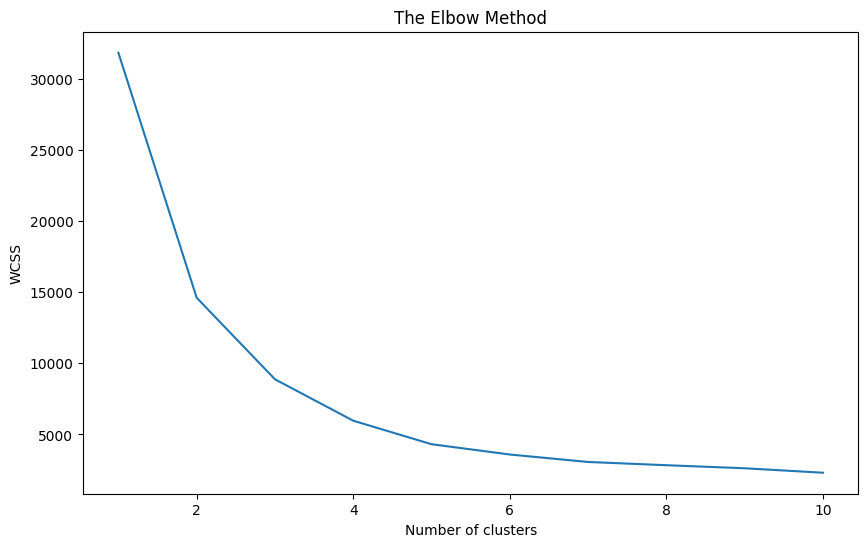

In [24]:
# Use the elbow method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_combined)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()


### Perform K-means with cluster = 4

In [25]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=5, n_init=10)
clusters = kmeans.fit_predict(X_combined)


# Assign cluster labels to each contributor
contributors_cluster = {contributor: cluster_label for contributor, cluster_label in zip(contributors, clusters)}


In [26]:
clusters

array([4, 4, 4, ..., 0, 0, 0], dtype=int32)

In [27]:
contributors_cluster

{'MeganTheCartoonist': 4,
 'SchleppyJ4': 4,
 'Warhawkgame128': 4,
 'm4imaimai': 0,
 'puffmouse': 0,
 'Italianman2733': 0,
 'Sirstupifie': 0,
 'jmairena20': 0,
 'rawrtherapy': 0,
 'faderjockey': 0,
 'ReactorCritical': 0,
 'D0nK3yd0Ng': 4,
 'Louiekid502': 0,
 'ghostwiththeleast': 0,
 'tayLORDoc': 4,
 'Curlyspice97': 4,
 'lewiss15': 0,
 'killerqween16': 0,
 'feelthebernerd': 4,
 'cncordray': 0,
 'Pegasus2731': 0,
 'RainbowDash0201': 0,
 'TheOneTrueAnimeLover': 0,
 'CCatProductions': 0,
 'Soflo-anarchy-crew': 0,
 'ilikescolouring': 0,
 'osmosis19': 0,
 'B1g_Ron': 4,
 'MithranArkanere': 0,
 'QueenB_50': 0,
 'I_dont_cuddle': 0,
 'WellDressedLobster': 4,
 'AnneHasThePlague2': 0,
 'SpartanElitism': 2,
 'john_muleaney': 4,
 'cutielocks': 0,
 'Wildcat_twister12': 4,
 'WoodFirePizzaIsGood': 0,
 'stellalunawitchbaby': 4,
 'RhymesWithMouthful': 4,
 'GoldenOwl25': 4,
 'BadJubie': 4,
 'joshysgirl7': 4,
 'elevatorfloor': 0,
 'Johnny-Sins_6942': 0,
 'anonuck': 0,
 'Five_Magix': 4,
 'scorpio_babe': 4,
 

### Word Cloud of each cluster 

In [28]:
def preprocess_and_tokenize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stop words, and lower case the words
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    return tokens

# Modify the cluster_texts creation to tokenize the texts
cluster_texts = {}

for item in data:
    contributor = item['author_details']['name']
    if True:#contributor in contributors_cluster:
        cluster_label = contributors_cluster[contributor]

        if cluster_label not in cluster_texts:
            cluster_texts[cluster_label] = []

        processed_post_text = preprocess_text(item['selftext'])
        cluster_texts[cluster_label].extend(processed_post_text)

        for comment in item['comments']:
            contributor = comment['author']
            if contributor in contributors_cluster:
                cluster_label = contributors_cluster[contributor]

                if cluster_label not in cluster_texts:
                    cluster_texts[cluster_label] = []

                processed_comment_text = preprocess_text(comment['body'])
                cluster_texts[cluster_label].extend(processed_comment_text)


In [29]:
cluster_texts.keys()

dict_keys([4, 0, 2, 1, 3])

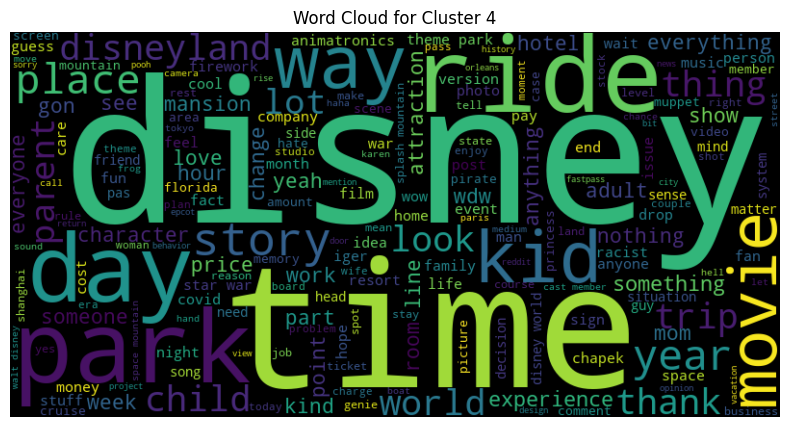

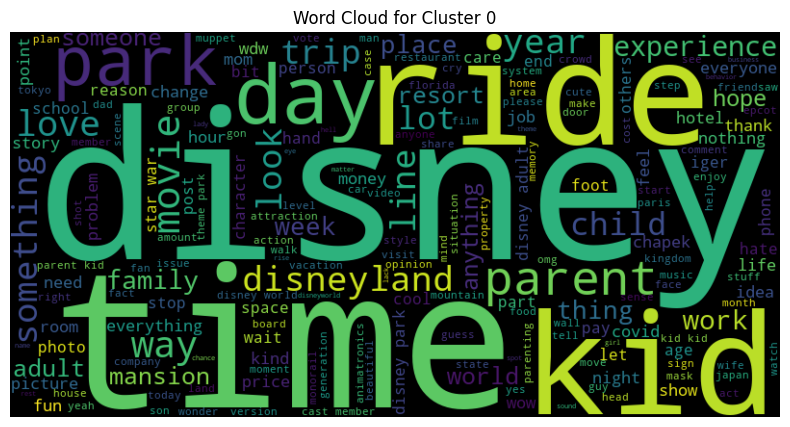

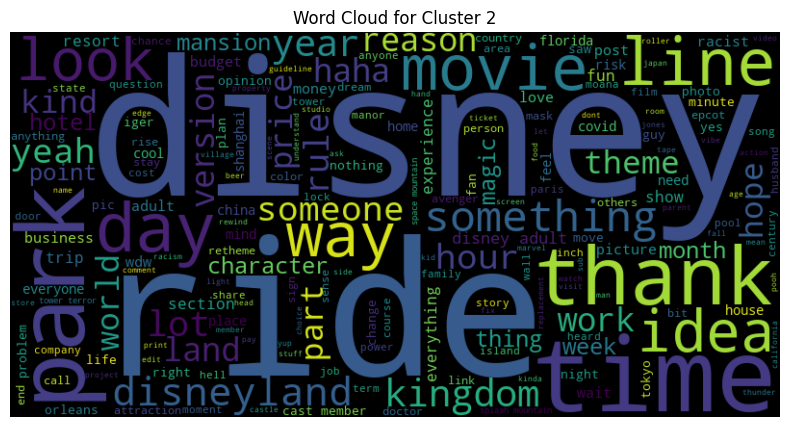

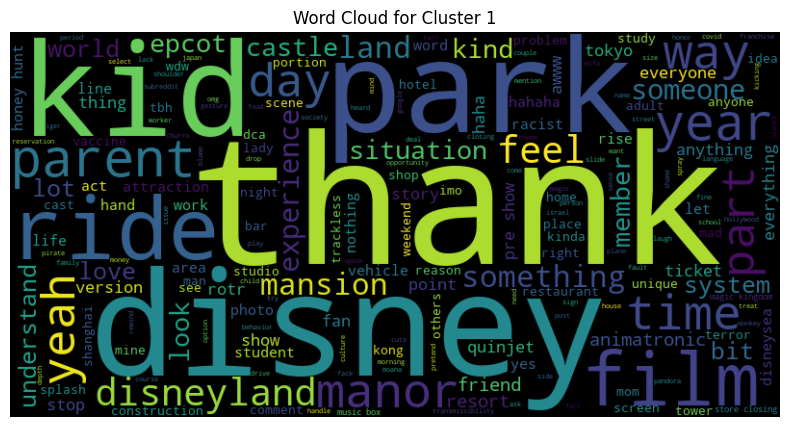

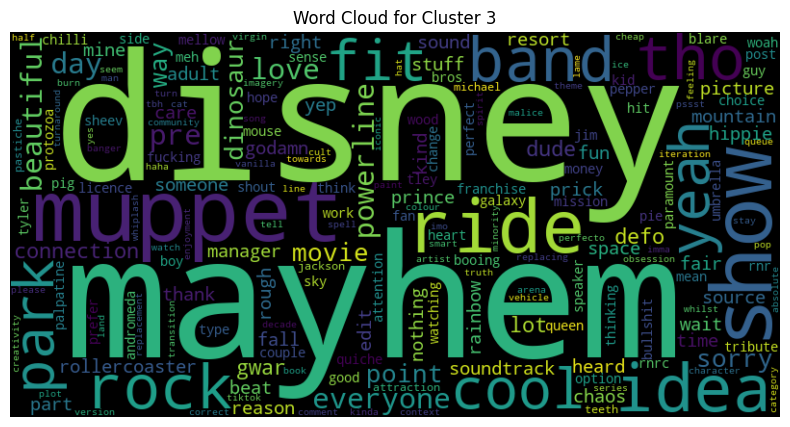

In [30]:
# Process texts and create word clouds for each cluster
for cluster_id, texts in cluster_texts.items():
    # combined_text = " ".join([preprocess_text(text) for text in texts])
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400).generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.show()

### Plot the dendrogram of words 

In [31]:

combined_texts = [" ".join(texts) for texts in cluster_texts.values()]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000)  # Limit number of features to top 1000
X_tfidf = vectorizer.fit_transform(combined_texts)


In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Transpose the TF-IDF matrix so that each row represents a word
X_tfidf_transposed = X_tfidf.transpose()

# Perform hierarchical clustering
Z = linkage(X_tfidf_transposed.toarray(), 'ward')


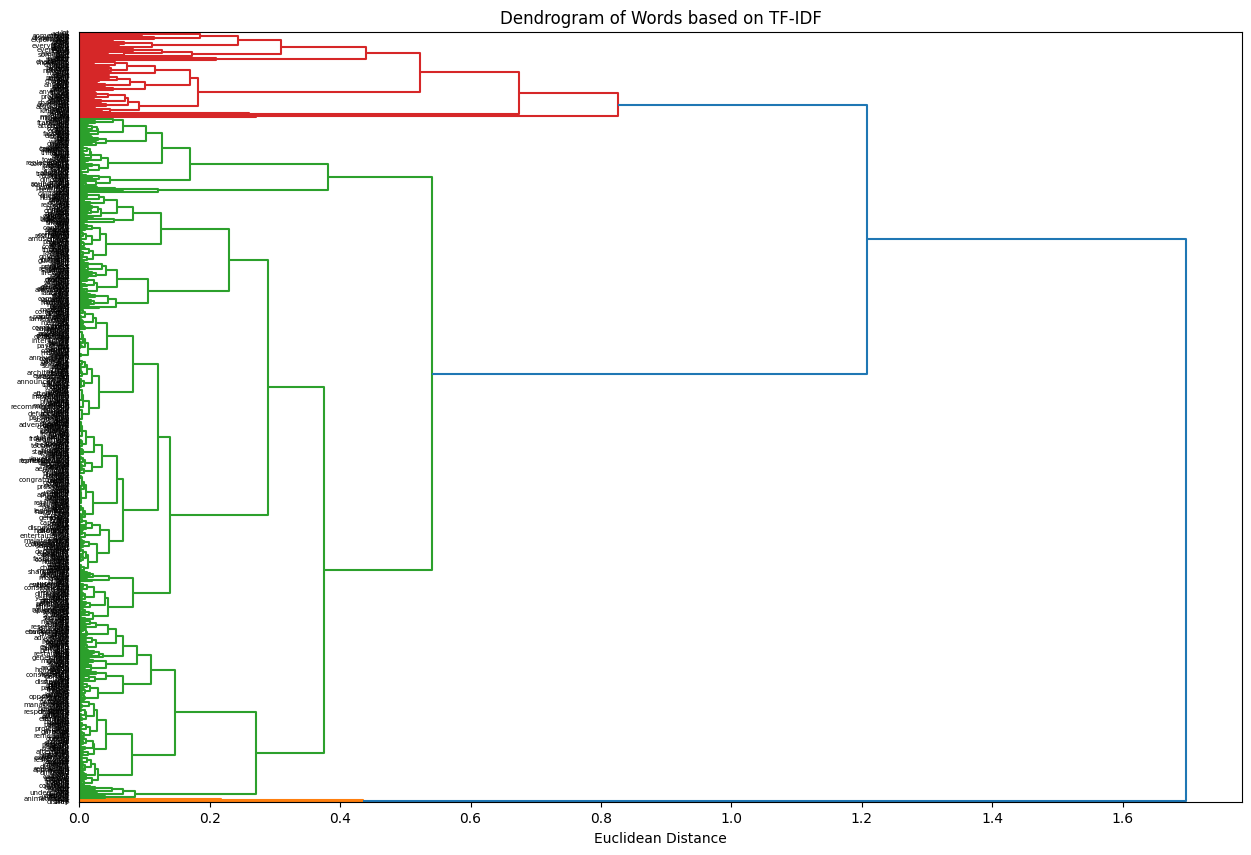

In [33]:
import matplotlib.pyplot as plt

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=feature_names, orientation='right')
plt.title("Dendrogram of Words based on TF-IDF")
plt.xlabel("Euclidean Distance")
plt.show()


### Topic modelling on the overall content 

In [34]:
all_text = [text for texts in cluster_texts.values() for text in texts]

cluster_dictionary_all = corpora.Dictionary([all_text])
cluster_corpus_all = [cluster_dictionary_all.doc2bow([text]) for text in all_text]

lda_model_all = gensim.models.ldamodel.LdaModel(cluster_corpus_all, num_topics=5, 
                                                id2word=cluster_dictionary_all, passes=15)

In [35]:
for idx, topic in lda_model_all.print_topics(-1):
    # Extract words from the topic string (removing weights)
    words = re.findall(r'"([^"]*)"', topic)
    
    # Join words into a sentence
    topic_sentence = ' '.join(words)
    
    print(f"Topic {idx + 1}: {topic_sentence}")


Topic 1: ride kind feel hour member money manor story star family
Topic 2: park day line look mansion someone work part hotel everything
Topic 3: disney time kid experience lot trip price week fun war
Topic 4: love something show thanks resort adult reason nothing fan anything
Topic 5: thank way disneyland year movie parent world idea thing point


### Check the top keywords used by influencers 

In [36]:
# and a dictionary 'contributors_cluster' mapping contributors to their clusters

cluster_influence = {cluster: {} for cluster in set(contributors_cluster.values())}

for contributor, cluster in contributors_cluster.items():
    if contributor in G:
        # Degree centrality as a measure of influence
        influence = G.degree[contributor]
        cluster_influence[cluster][contributor] = influence

# Identify top influencer in each cluster
top_influencers = {cluster: max(contributors, key=contributors.get) 
                   for cluster, contributors in cluster_influence.items()}

print("Top influencer in each cluster:", top_influencers)


Top influencer in each cluster: {0: 'AirMagiqueOfficial', 1: 'solojones1138', 2: 'EntertainmentQuick47', 3: 'Scrambled_59', 4: 'xJenniferocious'}


In [44]:
# Influencers to extract information about
influencers = top_influencers.values()

# Function to extract influencer information
def extract_influencer_info(data, influencers):
    influencer_info = []

    # Iterate through each post
    for post in data:
        # Check if the post author is an influencer
        if post['author_details']['name'] in influencers:
            influencer_info.append({
                'influencer': post['author_details']['name'],
                'description': post['author_details']['description'],
                'score': post.get('score', 0),
                'created_utc': post.get('created_utc', ''),
                'num_comments': post.get('num_comments', 0),
                'permalink': post.get('permalink', '')
            })

        # Iterate through each comment
        # for comment in post['comments']:
        #     if comment['author'] in influencers:
        #         influencer_info.append({
        #             'influencer': comment['author'],
        #             'body': comment.get('body', ''),
        #             'score': comment.get('score', 0),
        #             'created_utc': comment.get('created_utc', '')
        #         })

    return influencer_info

# Extracting information
influencer_data = pd.DataFrame(extract_influencer_info(data, influencers))
influencer_data['description'] = influencer_data['description'].fillna('')
influencer_data['num_comments'] = influencer_data['num_comments'].fillna(0)
influencer_data['permalink'] = influencer_data['permalink'].fillna('')
# influencer_data['body'] = influencer_data['body'].fillna('')


def custom_agg(series):
    if pd.api.types.is_numeric_dtype(series):
        return series.sum()
    elif pd.api.types.is_string_dtype(series):
        return ' '.join(series.dropna().unique())
    else:
        return series.iloc[0]

influencer_data_grouped = influencer_data.groupby('influencer').agg(custom_agg)


# influencer_data.groupby('influencer').sum()


influencer_data_grouped

description  \
influencer                                                                
AirMagiqueOfficial    AirMagique is an unofficial news, rumor, histo...   
EntertainmentQuick47                                                      
Scrambled_59          🏴󠁧󠁢󠁥󠁮󠁧󠁿, 19M, likes all art mediums (music, mo...   
solojones1138                                                             
xJenniferocious       Something something doggos something karma. I ...   

                      score                              created_utc  \
influencer                                                             
AirMagiqueOfficial     1250                      2023-02-16T23:00:44   
EntertainmentQuick47    826                      2023-04-28T00:42:59   
Scrambled_59           1269                      2023-05-12T22:50:06   
solojones1138          1469                      2023-09-27T17:57:22   
xJenniferocious        1978  2022-11-21T02:56:04 2023-04-26T16:04:01   

                      num_comments  \
influencer                           
AirMagiqueOfficial             298   
EntertainmentQuick47           169   
Scrambled_59                   247   
solojones1138                  609   
xJenniferocious                310   

                                                              permalink  
influencer                                                               
AirMagiqueOfficial    /r/disneyparks/comments/1143udh/guest_attempts...  
EntertainmentQuick47  /r/disneyparks/comments/131crya/whats_your_fav...  
Scrambled_59          /r/disneyparks/comments/13fzohl/ride_proposal_...  
solojones1138         /r/disneyparks/comments/16trfs3/poor_parenting...  
xJenniferocious       /r/disneyparks/comments/z0ngy5/disney_shocker_...

In [43]:
pd.__version__

'2.0.3'

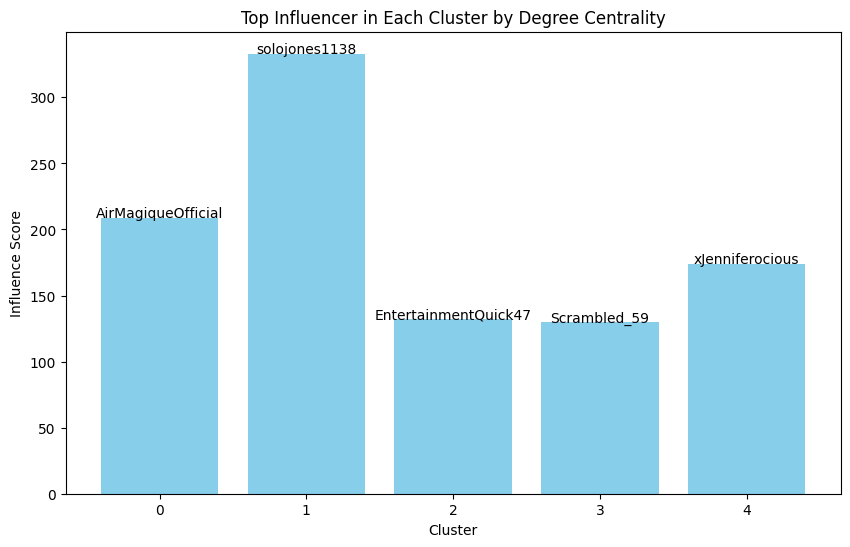

In [38]:
# Prepare data for the graph
clusters = list(top_influencers.keys())
influencers = [top_influencers[cluster] for cluster in clusters]
influence_scores = [cluster_influence[cluster][influencers[idx]] for idx, cluster in enumerate(clusters)]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(clusters, influence_scores, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Influence Score')
plt.title('Top Influencer in Each Cluster by Degree Centrality')
plt.xticks(clusters)
# plt.yticks(range(0, int(max(influence_scores)) + 1))

# Add text labels for the influencers
for idx, score in enumerate(influence_scores):
    plt.text(idx, score + 0.05, influencers[idx], ha='center')

plt.show()

In [39]:
top_contributor_texts_combined = {contributor: preprocess_text(' '.join(contributor_texts[contributor])) for contributor in contributor_texts if contributor in top_influencers.values()}
top_contributor_texts_combined

{'solojones1138': ['disney',
  'park',
  'anyone',
  'rise',
  'disney',
  'park',
  'disneyland',
  'sister',
  'time',
  'someone',
  'kid',
  'please',
  'disney',
  'kid',
  'street',
  'station',
  'family',
  'member',
  'member',
  'hey',
  'anything',
  'kid',
  'post',
  'lack',
  'manner',
  'disney',
  'park',
  'parent',
  'feel',
  'park',
  'blame',
  'parent',
  'yeah',
  'parent',
  'kid',
  'kid',
  'kid',
  'disney',
  'issue',
  'story',
  'situation',
  'problem',
  'deal',
  'abuse',
  'kid',
  'kid',
  'mind',
  'parent',
  'day',
  'party',
  'park',
  'hour',
  'place',
  'lot',
  'drunk',
  'handle',
  'yeah',
  'disney',
  'kid',
  'disney',
  'fault',
  'member',
  'place',
  'omg',
  'address',
  'child',
  'yeah',
  'lot',
  'confidence',
  'step',
  'epcot',
  'drink',
  'culture',
  'kid',
  'fight',
  'someone',
  'something',
  'something',
  'feel',
  'post',
  'covid',
  'generation',
  'bit',
  'laugh',
  'attempt',
  'trouble',
  'hmm',
  'disneylan

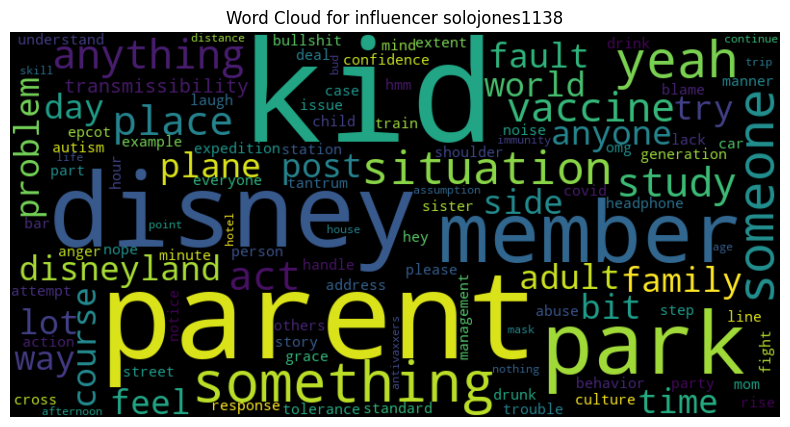

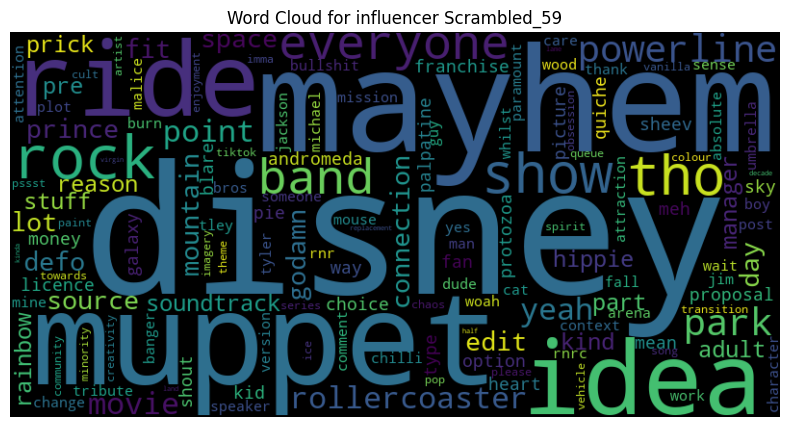

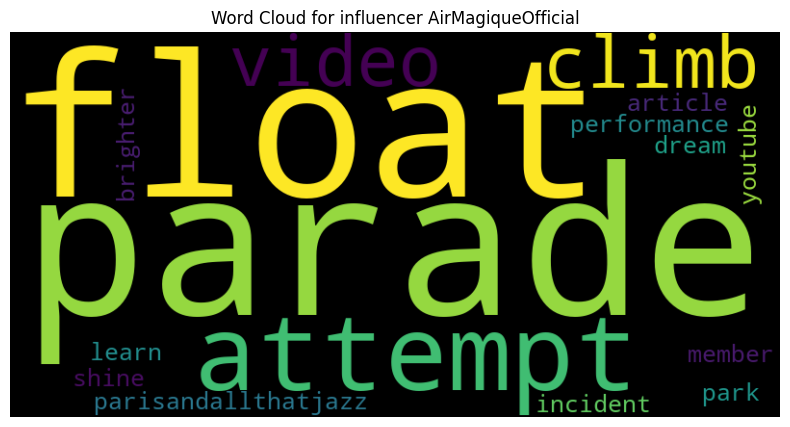

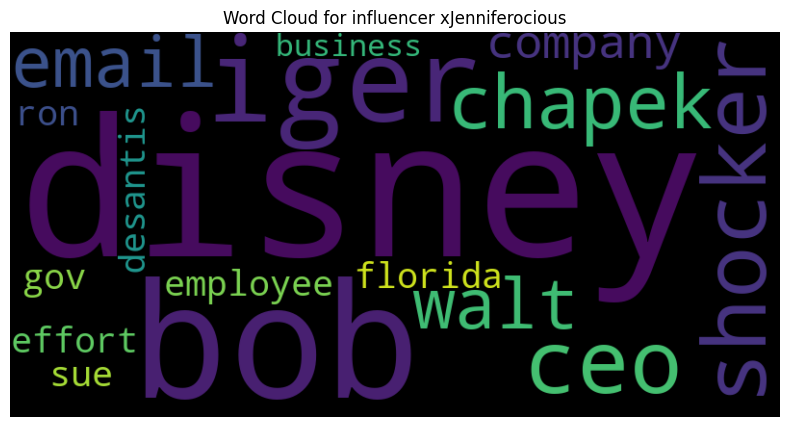

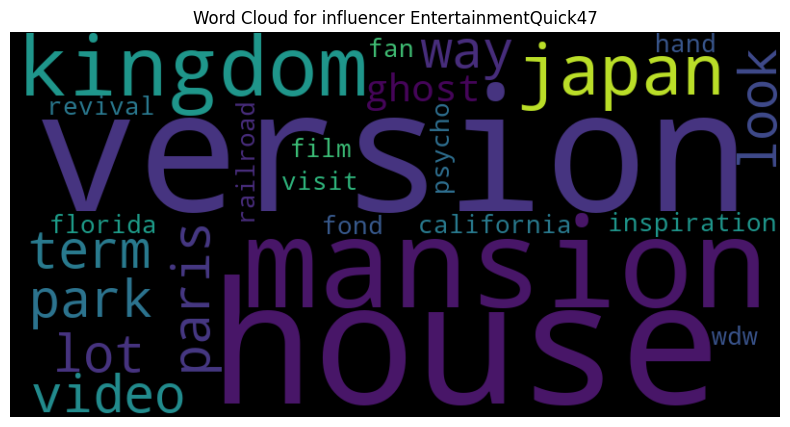

In [40]:
# Process texts and create word clouds for each cluster
for cluster_id, texts in top_contributor_texts_combined.items():
    # combined_text = " ".join([preprocess_text(text) for text in texts])
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400).generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for influencer {cluster_id}')
    plt.show()

In [41]:


# Create a dictionary and corpus for Topic Modeling
cluster_dictionary = {cluster: corpora.Dictionary([texts]) for cluster, texts in cluster_texts.items()}
cluster_corpus = {cluster: [cluster_dictionary[cluster].doc2bow(texts) for texts in [cluster_texts[cluster]]] 
                  for cluster in cluster_dictionary}

# Perform LDA Topic Modeling
lda_models = {cluster: gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=cluster_dictionary[cluster], passes=15)
              for cluster, corpus in cluster_corpus.items()}



In [42]:
# Display the topics for each cluster as sentences
for cluster, lda in lda_models.items():
    print(f"Topics for Cluster {cluster}:")
    for idx, topic in lda.print_topics(-1):
        # Extract words from the topic string (removing weights)
        words = re.findall(r'"([^"]*)"', topic)
        
        # Join words into a sentence
        topic_sentence = ' '.join(words)
        
        print(f"Topic {idx + 1}: {topic_sentence}")
    print("\n")

Topics for Cluster 4:
Topic 1: disney day time park kid ride way world parent movie
Topic 2: disney park time ride day kid way movie story world
Topic 3: disney time park day ride way movie year kid disneyland
Topic 4: park disney time ride day way movie place kid world
Topic 5: disney ride time day park kid world movie way year
Topic 6: disney park ride time day way kid movie story place
Topic 7: disney park day time ride kid story movie way world
Topic 8: ride disney day park time kid way world disneyland year
Topic 9: park disney time day ride kid way year world movie
Topic 10: disney ride park time day way movie trip world kid


Topics for Cluster 0:
Topic 1: disney time park parent kid day ride disneyland movie child
Topic 2: disney kid park time ride parent day way movie line
Topic 3: disney time park kid parent day ride way line disneyland
Topic 4: kid park disney ride time parent day movie look way
Topic 5: disney day kid time ride parent park love movie way
Topic 6: disney kid